# Client: Sales Effectiveness | Category: Product Sales
# Project Ref: PM-PR-0019

## Business Case:
FicZon Inc is an IT solution provider with products ranging from on-
premises products to SAAS based solutions. FicZon major leads
generation channel is digital and through their website.
FicZon business is majorly dependent on the sales force
effectiveness. As the market is maturing and more new competitors
entering the market, FicZon is experiencing the dip in sales.
Effective sales is dependent on lead quality and as of now, this is
based on manual categorization and highly depended on sales staff.
Though there is a quality process, which continuously updates the
lead categorization, it’s value is in for post analysis, rather than
conversation.
FicZon wants to explore Machine Learning to pre-categorize the lead
quality and as result, expecting significant increase in sales
effectiveness.
## PROJECT GOAL:
1. Data exploration insights – Sales effectiveness.
2. ML model to predict the Lead Category (High Potential , Low
Potential)

## Importing Libraries

In [1]:
!pip install pymysql
!pip install mysql-connector

  Using cached PyMySQL-1.0.2-py3-none-any.whl (43 kB)
  Using cached mysql_connector-2.2.9-cp39-cp39-win_amd64.whl


In [1]:
import os
import mysql.connector
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Importing the Data

In [2]:
connection=mysql.connector.connect(host = '18.136.157.135',
                                  user='dm_team2',
                                  password='DM!$Team&27@9!20!',
                                   database='project_sales')

In [3]:
query = "select * from data" # SQL statement
output = pd.read_sql(query,connection)
print(output.shape)

(7422, 9)


In [4]:
output.to_csv('df.csv')

In [5]:
df=pd.read_csv('df.csv')

In [6]:
df.head()

,Unnamed: 0,Created,Product_ID,Source,Mobile,EMAIL,Sales_Agent,Location,Delivery_Mode,Status
0,0,14-11-2018 10:05,NaN,Website,984XXXXXXX,aXXXXXXX@gmail.com,Sales-Agent-11,NaN,Mode-5,Open
1,1,14-11-2018 09:22,NaN,Website,XXXXXXX,#VALUE!,Sales-Agent-10,NaN,Mode-5,Open
2,2,14-11-2018 09:21,NaN,Website,XXXXXXX,dXXXXXXX@yahoo.com,Sales-Agent-10,NaN,Mode-5,Open
3,3,14-11-2018 08:46,NaN,Website,XXXXXXX,wXXXXXXX@gmail.com,Sales-Agent-10,NaN,Mode-5,Open
4,4,14-11-2018 07:34,NaN,Website,XXXXXXX,cXXXXXXX@gmail.com,Sales-Agent-10,NaN,Mode-5,Open


In [7]:
df.drop('Unnamed: 0',axis=1,inplace=True)

## Basic Checks

In [8]:
df.describe()

,Product_ID
count,7364.000000
mean,15.947311
std,6.072937
min,0.000000
25%,12.000000
50%,18.000000
75%,19.000000
max,28.000000


In [9]:
df.describe(include='O')

,Created,Source,Mobile,EMAIL,Sales_Agent,Location,Delivery_Mode,Status
count,7422,7405,5612,7422,7399,7364,7422,7422
unique,6752,25,486,883,12,17,5,11
top,26-09-2018 11:30,Call,XXXXXXX,#VALUE!,Sales-Agent-4,Other Locations,Mode-5,Junk Lead
freq,4,2547,222,1701,1500,2500,2975,1536


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7422 entries, 0 to 7421
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Created        7422 non-null   object 
 1   Product_ID     7364 non-null   float64
 2   Source         7405 non-null   object 
 3   Mobile         5612 non-null   object 
 4   EMAIL          7422 non-null   object 
 5   Sales_Agent    7399 non-null   object 
 6   Location       7364 non-null   object 
 7   Delivery_Mode  7422 non-null   object 
 8   Status         7422 non-null   object 
dtypes: float64(1), object(8)
memory usage: 522.0+ KB


In [11]:
# Dropping invalid columns
df.drop(['Mobile'],axis=1,inplace=True)
df.drop(['EMAIL'],axis=1,inplace=True)
df.drop(['Created'],axis=1,inplace=True)

In [12]:
numerical=df.describe()
categorical=df.describe(include='O')

In [13]:
df.isnull().sum()

Product_ID       58
Source           17
Sales_Agent      23
Location         58
Delivery_Mode     0
Status            0
dtype: int64

### Observation from above analysis
####  1.There is only one numerical feature and five are categorical feature.
####  2.Missing values are present in 'Product_ID','Source','Sales_Agent' and 'Location'.


## EDA and Data Preprocessing

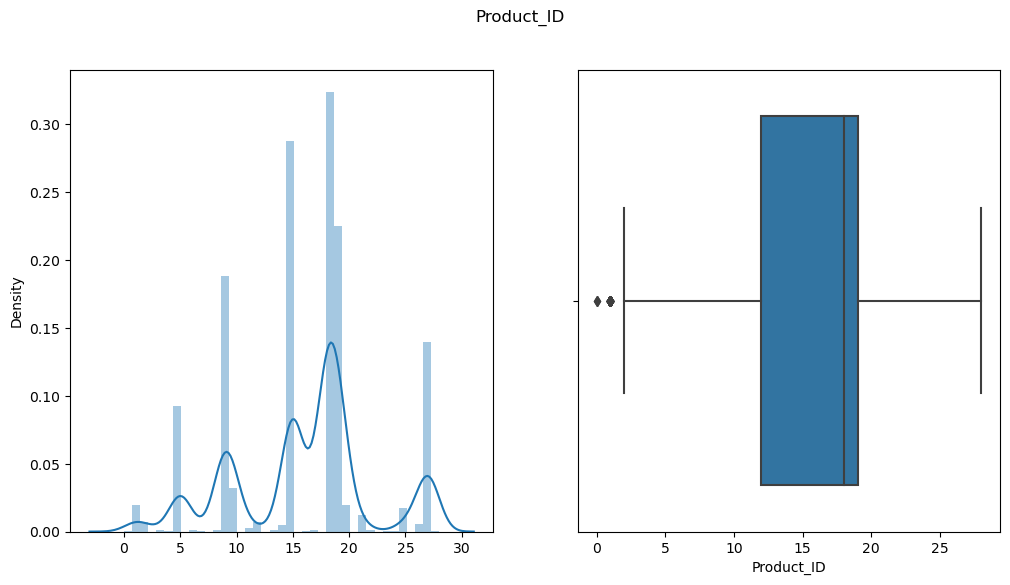

In [14]:
for feature in numerical.columns:
    fig=plt.figure(figsize=(12,6))
    fig.suptitle(feature)
    ax1=plt.subplot(1,2,1)
    sns.distplot(x=df[feature],kde=True,ax=ax1)
    ax2=plt.subplot(1,2,2)
    sns.boxplot(x=df[feature],ax=ax2);

### Treating Missing values

In [15]:
#filling the missing values with Mode
df['Product_ID'].fillna(df['Product_ID'].mode()[0], inplace=True)
df['Source'].fillna(df['Source'].mode()[0], inplace=True)
df['Sales_Agent'].fillna(df['Sales_Agent'].mode()[0], inplace=True)
df['Location'].fillna(df['Location'].mode()[0], inplace=True)

In [16]:
df.head()

,Product_ID,Source,Sales_Agent,Location,Delivery_Mode,Status
0,18.0,Website,Sales-Agent-11,Other Locations,Mode-5,Open
1,18.0,Website,Sales-Agent-10,Other Locations,Mode-5,Open
2,18.0,Website,Sales-Agent-10,Other Locations,Mode-5,Open
3,18.0,Website,Sales-Agent-10,Other Locations,Mode-5,Open
4,18.0,Website,Sales-Agent-10,Other Locations,Mode-5,Open


In [17]:
df.isnull().sum()

Product_ID       0
Source           0
Sales_Agent      0
Location         0
Delivery_Mode    0
Status           0
dtype: int64

In [18]:
# Compressing and Merging the labels in column
df.Source.replace(['Live Chat-Direct','Live Chat-Google Organic','Live Chat -PPC','Live Chat-Blog','Live Chat-Quora',
                    'Live Chat-CPC','Live Chat-Google Ads','Live Chat-Adwords Remarketing','Live Chat-Youtube',
                    'Live Chat-Justdial'],'Live Chat',inplace=True)
df.Source.replace(['Existing Client','CRM form','Personal Contact'],'Existing Customer',inplace=True)
df.Source.replace('By Recommendation','Customer Referral',inplace=True)
df.Source.replace(['US Website','Just Dial'],'Website',inplace=True)
df.Source.replace(['E-mail Campaign','SMS Campaign','E-Mail Message','Other'],'Campaign',inplace=True)

In [19]:
df.Location.replace(['UAE','USA','UK','AUSTRALIA','Singapore','Malaysia','EUROPE'],'Foreign',inplace=True)
df.Location.replace(['Howrah','Kolkata','Trivandrum'],'Other Locations',inplace=True)

In [20]:
df.Product_ID.replace(['8','6','3','17','22','11','7','28','0','23','24','16','13','4','14','26','12','2','21','25'],
                        'Less Sold Product',inplace=True)

In [21]:
# Defining 'Status' as 'Good' or 'Bad'
df.Status.replace(['CONVERTED','converted','In Progress Positive','Potential','Long Term','Open'],'Good',inplace=True)
df.Status.replace(['LOST','In Progress Negative','Not Responding','Junk Lead','Just Enquiry'],'Bad',inplace=True)

In [22]:
df.head()

,Product_ID,Source,Sales_Agent,Location,Delivery_Mode,Status
0,18.0,Website,Sales-Agent-11,Other Locations,Mode-5,Good
1,18.0,Website,Sales-Agent-10,Other Locations,Mode-5,Good
2,18.0,Website,Sales-Agent-10,Other Locations,Mode-5,Good
3,18.0,Website,Sales-Agent-10,Other Locations,Mode-5,Good
4,18.0,Website,Sales-Agent-10,Other Locations,Mode-5,Good


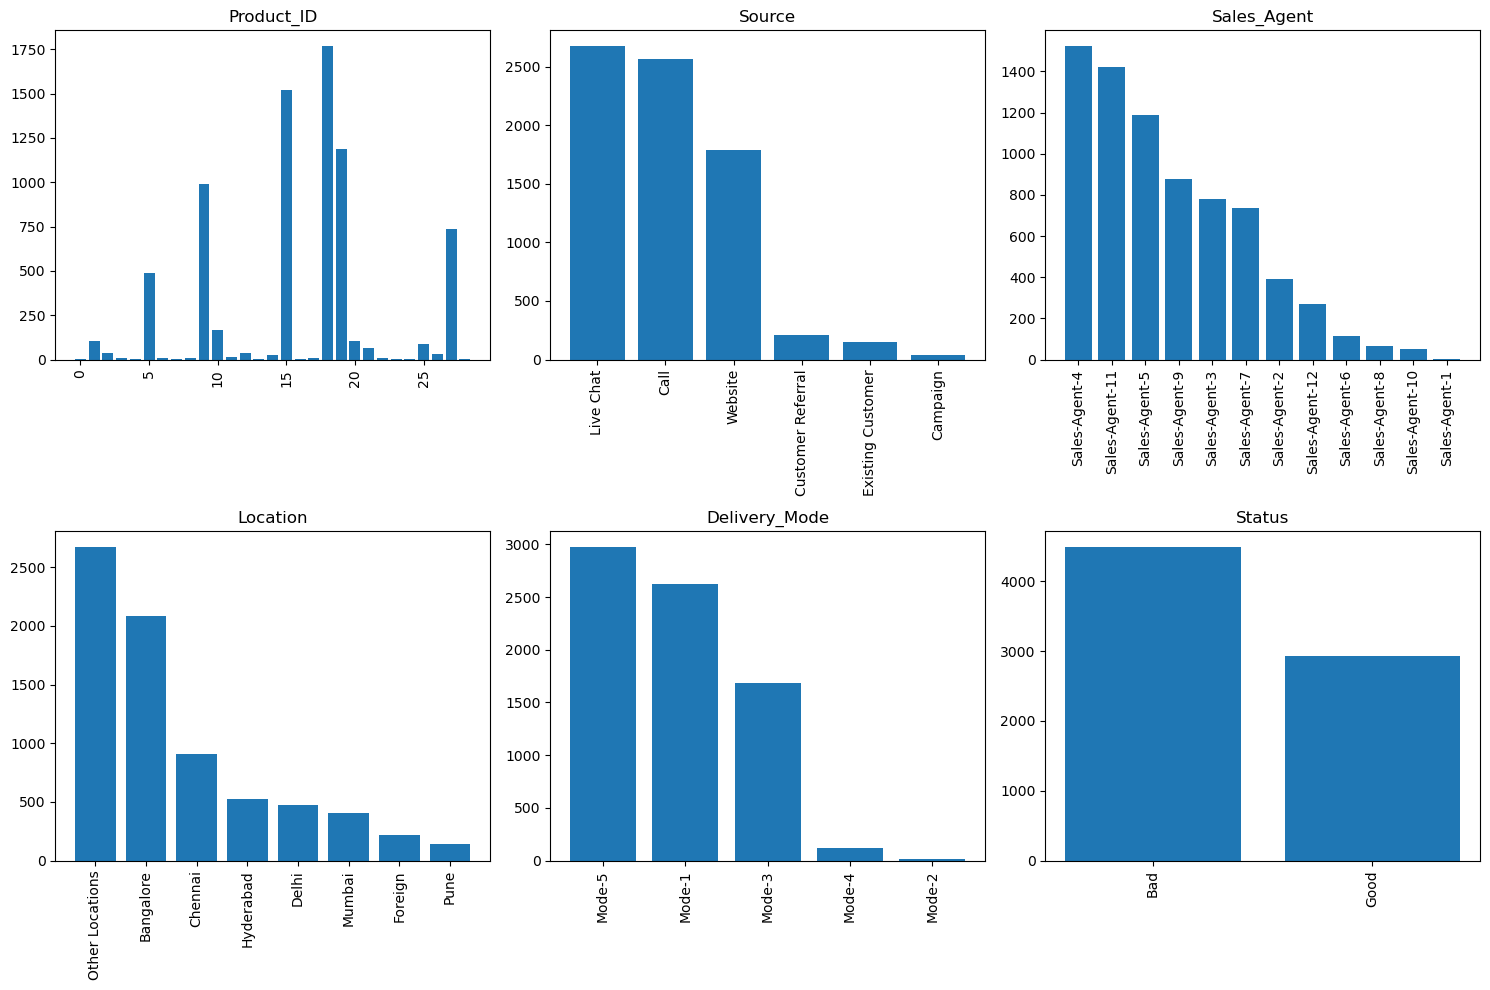

In [23]:
# Create a dictionary to store the column names and their counts
col_counts = {'Product_ID': df.Product_ID.value_counts(),
              'Source': df.Source.value_counts(),
              'Sales_Agent': df.Sales_Agent.value_counts(),
              'Location': df.Location.value_counts(),
              'Delivery_Mode': df.Delivery_Mode.value_counts(),
              'Status': df.Status.value_counts()}

# Plot each column in a subplot
fig, axs = plt.subplots(2, 3, figsize=(15,10))
for i, col in enumerate(col_counts):
    axs[i//3, i%3].bar(col_counts[col].index, col_counts[col].values)
    axs[i//3, i%3].set_title(col)
    axs[i//3, i%3].tick_params(axis='x', labelrotation = 90)

plt.tight_layout()
plt.show()
    

### Normalization

In [24]:
numerical=df.describe()
features=[feature for feature in numerical if df[feature].all()!=0]

In [25]:
for feature in features:
    df[feature]=np.log(df[feature])

### Converting Categorical Data

In [26]:
from sklearn.preprocessing import LabelEncoder
categorical=df.describe(include='O')
label = LabelEncoder()
for feature in categorical.columns:
    df[feature]=label.fit_transform(df[feature])

In [27]:
df.head()

,Product_ID,Source,Sales_Agent,Location,Delivery_Mode,Status
0,18.0,5,2,6,4,1
1,18.0,5,1,6,4,1
2,18.0,5,1,6,4,1
3,18.0,5,1,6,4,1
4,18.0,5,1,6,4,1


### Scaling

In [28]:
features=df.columns[:5]
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df[features])

StandardScaler()

In [29]:
df=pd.concat([df[['Status']].reset_index(drop=True),pd.DataFrame(scaler.transform(df[features]),columns=features)],axis=1)

In [30]:
df.head()

,Status,Product_ID,Source,Sales_Agent,Location,Delivery_Mode
0,1,0.336555,1.061031,-1.403695,1.0731,1.087458
1,1,0.336555,1.061031,-1.754879,1.0731,1.087458
2,1,0.336555,1.061031,-1.754879,1.0731,1.087458
3,1,0.336555,1.061031,-1.754879,1.0731,1.087458
4,1,0.336555,1.061031,-1.754879,1.0731,1.087458


### Observation from above Analysis
#### 1. Compressing and Merging the labels in column so as to balance the data
#### 2.Product_ID has outilers and the feature is normalized.
#### 3.Missing values are handled using mode.
#### 4.Categorical features are converted to numerical and are then scaled.

### Feature Selection

In [31]:
# Checking the correlation coeffecient
corr=df.corr()
corr

,Status,Product_ID,Source,Sales_Agent,Location,Delivery_Mode
Status,1.000000,0.086057,-0.010845,0.119996,-0.331949,-0.208119
Product_ID,0.086057,1.000000,0.064199,0.002746,-0.039612,-0.033046
Source,-0.010845,0.064199,1.000000,-0.030093,0.001503,-0.209298
Sales_Agent,0.119996,0.002746,-0.030093,1.000000,-0.151816,-0.233541
Location,-0.331949,-0.039612,0.001503,-0.151816,1.000000,0.419509
Delivery_Mode,-0.208119,-0.033046,-0.209298,-0.233541,0.419509,1.000000


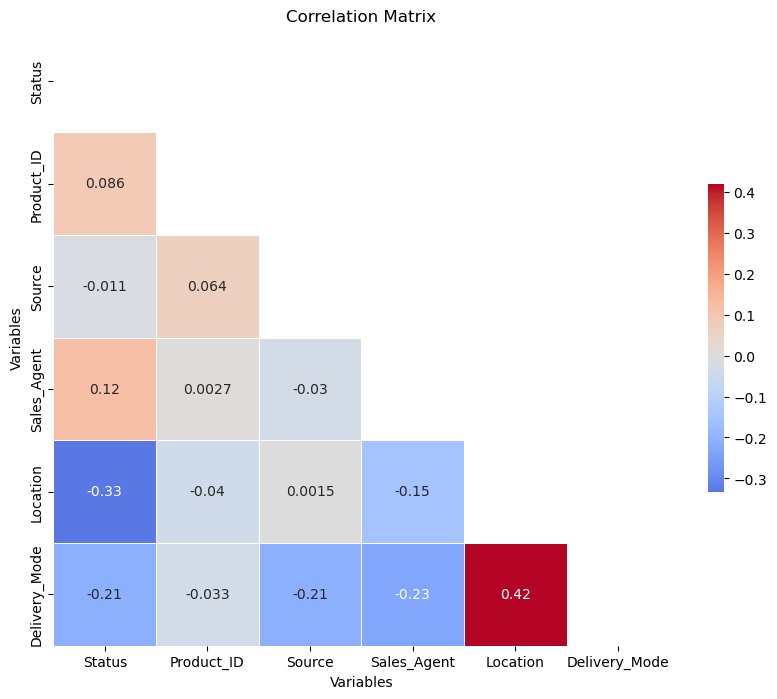

In [32]:
# creating mask for upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10,8))

# create heatmap with seaborn
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

# set title and axis labels
ax.set_title('Correlation Matrix')
ax.set_xlabel('Variables')
ax.set_ylabel('Variables')

# display plot
plt.show()

### Model Creation

In [33]:
X = df.drop('Status', axis=1)
y = df['Status']

In [34]:
# Splitting into training and testing data for accuracy
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=10)

In [35]:
y_train.value_counts()

0    3158
1    2037
Name: Status, dtype: int64

In [36]:
X_train.shape

(5195, 5)

In [37]:
X_test.shape

(2227, 5)

In [38]:
# SMOTE for sampling technique
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)


In [39]:
# checking dataset balanced or not
y_train.value_counts()

1    3158
0    3158
Name: Status, dtype: int64

### Observation from above Analysis
#### The imbalanced target feature is balanced using SMOTE

### Logistic Regression

In [40]:
# Training the model
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
logr.fit(X_train,y_train)

LogisticRegression()

In [41]:
# Predicting the model
y_pred_log = logr.predict(X_test)


In [42]:
# Finding accuracy, precision, recall and confusion matrix
accuracy = accuracy_score(y_test, y_pred_log)
print("Accuracy:", accuracy)
print(classification_report(y_test,y_pred_log))

Accuracy: 0.6641221374045801
              precision    recall  f1-score   support

           0       0.74      0.67      0.70      1333
           1       0.57      0.66      0.61       894

    accuracy                           0.66      2227
   macro avg       0.66      0.66      0.66      2227
weighted avg       0.67      0.66      0.67      2227



In [43]:
print(confusion_matrix(y_test,y_pred_log))

[[890 443]
 [305 589]]


### Support Vector Machine

In [44]:
# Training the model
parameters = {'kernel': ['rbf'], 'gamma': [0.1,1,5], 'C': [0.1,1,10,100]}
rbf_svc = RandomizedSearchCV(SVC(),parameters).fit(X_train,y_train)

In [45]:
rbf_svc.best_params_

{'kernel': 'rbf', 'gamma': 5, 'C': 10}

In [46]:
# Predicting the model
y_predict_svm = rbf_svc.predict(X_test)

In [47]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_svm))
print(classification_report(y_test,y_predict_svm))

0.6722047597665021
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      1333
           1       0.59      0.62      0.60       894

    accuracy                           0.67      2227
   macro avg       0.66      0.66      0.66      2227
weighted avg       0.68      0.67      0.67      2227



In [48]:
print(confusion_matrix(y_test,y_predict_svm))

[[939 394]
 [336 558]]


In [49]:
#with grid searchCV
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 10],
}

# Create the SVM model
svm = SVC(kernel='rbf')

# Perform grid search cross-validation to find the best hyperparameters
grid = GridSearchCV(svm, param_grid, cv=5)
grid.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid.best_params_)

# Evaluate the model on the test set
y_pred = grid.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))


Best hyperparameters: {'C': 10, 'gamma': 10}
0.6766951055231253
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1333
           1       0.60      0.60      0.60       894

    accuracy                           0.68      2227
   macro avg       0.66      0.66      0.66      2227
weighted avg       0.68      0.68      0.68      2227



### Decision Tree 

In [50]:
# Training the model
from sklearn.tree import DecisionTreeClassifier

classifier_dtg=DecisionTreeClassifier(random_state=42,splitter='best')
parameters=[{'min_samples_split':[2,3,4,5],'criterion':['gini']},{'min_samples_split':[2,3,4,5],'criterion':['entropy']}]

model_griddtree=GridSearchCV(estimator=classifier_dtg, param_grid=parameters, scoring='accuracy',cv=10)
model_griddtree.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid=[{'criterion': ['gini'],
                          'min_samples_split': [2, 3, 4, 5]},
                         {'criterion': ['entropy'],
                          'min_samples_split': [2, 3, 4, 5]}],
             scoring='accuracy')

In [51]:
model_griddtree.best_params_

{'criterion': 'entropy', 'min_samples_split': 5}

In [52]:
# Predicting the model
y_predict_dtree = model_griddtree.predict(X_test)

In [53]:
# Finding accuracy, precision, recall and confusion matrix
print('accuracy:',accuracy_score(y_test,y_predict_dtree))
print(classification_report(y_test,y_predict_dtree))

accuracy: 0.6811854512797485
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      1333
           1       0.62      0.55      0.58       894

    accuracy                           0.68      2227
   macro avg       0.67      0.66      0.66      2227
weighted avg       0.68      0.68      0.68      2227



In [54]:
print(confusion_matrix(y_test,y_predict_dtree))

[[1027  306]
 [ 404  490]]


### Random Forest 

In [55]:
# Training the model
from sklearn.ensemble import RandomForestClassifier

classifier_rfg=RandomForestClassifier(random_state=33,n_estimators=23)
parameters=[{'min_samples_split':[2,3,4,5],'criterion':['gini','entropy'],'min_samples_leaf':[1,2,3]}]

model_gridrf=GridSearchCV(estimator=classifier_rfg, param_grid=parameters, scoring='accuracy',cv=10)
model_gridrf.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=23, random_state=33),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'min_samples_leaf': [1, 2, 3],
                          'min_samples_split': [2, 3, 4, 5]}],
             scoring='accuracy')

In [56]:
model_gridrf.best_params_

{'criterion': 'gini', 'min_samples_leaf': 3, 'min_samples_split': 2}

In [57]:
# Predicting the model
y_predict_rf = model_gridrf.predict(X_test)

In [58]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_rf))
print(classification_report(y_test,y_predict_rf))

0.6910642119443197
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1333
           1       0.61      0.63      0.62       894

    accuracy                           0.69      2227
   macro avg       0.68      0.68      0.68      2227
weighted avg       0.69      0.69      0.69      2227



In [59]:
print(confusion_matrix(y_test,y_predict_rf))

[[979 354]
 [334 560]]


### Naive Bayes Bernoulli

In [60]:
# Training the model
from sklearn.naive_bayes import BernoulliNB
model_nb = BernoulliNB()
model_nb.fit(X_train,y_train)

BernoulliNB()

In [61]:
# Predicting the model
y_predict_nb = model_nb.predict(X_test)

In [62]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_nb))
print(classification_report(y_test,y_predict_nb))

0.6506511001347104
              precision    recall  f1-score   support

           0       0.76      0.60      0.67      1333
           1       0.55      0.72      0.62       894

    accuracy                           0.65      2227
   macro avg       0.66      0.66      0.65      2227
weighted avg       0.68      0.65      0.65      2227



In [63]:
print(confusion_matrix(y_test,y_predict_nb))

[[805 528]
 [250 644]]


### K-Nearest Nieghbor

In [64]:
# Training the model
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=6,metric='euclidean') # Maximum accuracy for n=10
model_knn.fit(X_train,y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=6)

In [65]:
# Predicting the model
y_predict_knn = model_knn.predict(X_test)

In [66]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_knn))
print(classification_report(y_test,y_predict_knn))

0.6874719353390211
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      1333
           1       0.63      0.53      0.58       894

    accuracy                           0.69      2227
   macro avg       0.67      0.66      0.66      2227
weighted avg       0.68      0.69      0.68      2227



In [67]:
print(confusion_matrix(y_test,y_predict_knn))

[[1057  276]
 [ 420  474]]


### XGBoost Classifier

In [68]:
# Training the model
from xgboost import XGBClassifier
model_xgb = XGBClassifier(n_estimators=450,max_depth=17,gamma=5,learning_rate=0.01,random_state=10)
model_xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=450, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [69]:
# Predicting the model
y_predict_xgb = model_xgb.predict(X_test)

In [70]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_xgb))
print(classification_report(y_test,y_predict_xgb))

0.7112707678491244
              precision    recall  f1-score   support

           0       0.76      0.75      0.76      1333
           1       0.64      0.65      0.65       894

    accuracy                           0.71      2227
   macro avg       0.70      0.70      0.70      2227
weighted avg       0.71      0.71      0.71      2227



In [71]:
print(confusion_matrix(y_test,y_predict_xgb))

[[999 334]
 [309 585]]


### Artificial Neural Network

In [72]:
# Training the model
from sklearn.neural_network import MLPClassifier
model_mlp = MLPClassifier(hidden_layer_sizes=(100,100,100),batch_size=10,learning_rate_init=0.01,max_iter=2000,random_state=10)
model_mlp.fit(X_train,y_train)

MLPClassifier(batch_size=10, hidden_layer_sizes=(100, 100, 100),
              learning_rate_init=0.01, max_iter=2000, random_state=10)

In [73]:
# Predicting the model
y_predict_mlp = model_mlp.predict(X_test)

In [74]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_mlp))
print(classification_report(y_test,y_predict_mlp))

0.6829815895823979
              precision    recall  f1-score   support

           0       0.76      0.69      0.72      1333
           1       0.59      0.68      0.63       894

    accuracy                           0.68      2227
   macro avg       0.68      0.68      0.68      2227
weighted avg       0.69      0.68      0.69      2227



In [75]:
print(confusion_matrix(y_test,y_predict_mlp))

[[917 416]
 [290 604]]


## XGBoost Classifier model performs well compared to other model
### Lead Category: High Potential----Staus:Good, Low Potential---Status:Bad

### Creating A pickled file

In [76]:
import pickle

# Save the trained model to a file
with open('FicZon_Sales_Lead.pkl', 'wb') as file:
    pickle.dump(model_xgb, file)


In [77]:
# Load the saved model from the file
with open('FicZon_Sales_Lead.pkl', 'rb') as file:
    model_xgb = pickle.load(file)


## MODEL REPORT

## 1. Logistic Regression

This type of statistical model (also known as logit model) is often used for classification and predictive analytics. Logistic regression estimates the probability of an event occurring, such as voted or didn’t vote, based on a given dataset of independent variables. Since the outcome is a probability, the dependent variable is bounded between 0 and 1.

        The Accuracy of this model is 0.6641221374045801 

## 2. Support Vector Machine

Support Vector Machine or SVM is one of the most popular Supervised Learning algorithms, which is used for Classification as well as Regression problems. However, primarily, it is used for Classification problems in Machine Learning.

      The Accuracy of this model is 0.6722047597665021

## 3. Decision Tree

A decision tree is a non-parametric supervised learning algorithm, which is utilized for both classification and regression tasks. It has a hierarchical, tree structure, which consists of a root node, branches, internal nodes and leaf nodes.

         The Accuracy of this model is  0.6811854512797485

## 4. Random Forest

Random forest is a commonly-used machine learning algorithm trademarked by Leo Breiman and Adele Cutler, which combines the output of multiple decision trees to reach a single result. Its ease of use and flexibility have fueled its adoption, as it handles both classification and regression problems.


     The Accuracy of this model is 0.6910642119443197

## 5. Naive Bayes Burnoulli

This is used for discrete data and it works on Bernoulli distribution. The main feature of Bernoulli Naive Bayes is that it accepts features only as binary values like true or false, yes or no, success or failure, 0 or 1 and so on. So when the feature values are binary we know that we have to use Bernoulli Naive Bayes classifier.


     The Accuracy of this model is 0.6506511001347104

## 6. K Nearest Neighbour

The k-nearest neighbors algorithm, also known as KNN or k-NN, is a non-parametric, supervised learning classifier, which uses proximity to make classifications or predictions about the grouping of an individual data point.

      The Accuracy of this model is 0.6874719353390211

## 7. XGBoost Classifier

 XGBoost is an ensemble learning algorithm meaning that it combines the results of many models, called base learners to make a prediction. Just like in Random Forests, XGBoost uses Decision Trees as base learners: Image by the author. Decision tree to predict rain.
        
            The Accuracy of this model is 0.7112707678491244

## 8. Artificial Neural Network

Artificial neural networks (ANNs), usually simply called neural networks (NNs) or neural nets, are computing systems inspired by the biological neural networks that constitute animal brains.

   The Accuracy of the model is 0.6829815895823979

#### As we the modek which performs depends the accuracy, the higher the accuracy the model fits better .From the above model report we can see that XGBoost Classifier has the highest accuracy , this model suits good  to predict the Lead Category so as to increase the sales effectiveness.